Note:  
This notebook was executed on google colab pro.

In [ ]:
!pip3 install pytorch-lightning --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/atmacup11/experiments')

# Settings

In [ ]:
EXP_NO = 13
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = True

In [ ]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

In [ ]:
MODEL_NAME = 'vgg'
BATCH_SIZE = 128
NUM_EPOCHS = 50

# Library

In [ ]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score
# from sklearnex import patch_sklearn
from pytorch_lightning import seed_everything
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torchvision import transforms

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from dataset import load_csvfiles, load_photofile,load_photofiles, AtmaImageDatasetV02
from folder import experiment_dir_of
from models import initialize_model
from utils import train_model, predict_by_model

In [ ]:
pd.options.display.float_format = '{:.5f}'.format

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Prepare directory

In [ ]:
output_dir = experiment_dir_of(EXP_NO)

In [ ]:
output_dir

'../scripts/../experiments/exp013'

# Prepare logger

In [ ]:
logger = getLogger(__name__)

In [ ]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [ ]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-20 19:38:35,435 - __main__ - INFO - Experiment no: 13
2021-07-20 19:38:35,436 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-20 19:38:35,438 - __main__ - INFO - SEED: 1
2021-07-20 19:38:35,440 - __main__ - INFO - REGRESSION: True


# Load csv files

In [ ]:
SINCE = time.time()

In [ ]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-20 19:38:35,464 - __main__ - DEBUG - Start loading csv files (0.010 seconds passed)
2021-07-20 19:38:35,499 - __main__ - DEBUG - Complete loading csv files (0.046 seconds passed)


In [ ]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [ ]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Cross validation

In [ ]:
seed_everything(SEED)

Global seed set to 1


1

In [ ]:
train.set_index('object_id', inplace=True)

2021-07-20 19:38:35,709 - __main__ - DEBUG - Start fold 1 (0.255 seconds passed)
2021-07-20 19:38:35,715 - __main__ - DEBUG - Start training model (0.262 seconds passed)
2021-07-20 19:38:40,125 - __main__ - DEBUG - Epoch 0/49
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
2021-07-20 19:44:15,905 - __main__ - DEBUG - train Loss: 11629.7947
2021-07-20 19:45:54,760 - __main__ - DEBUG - val Loss: 1.4750
2021-07-20 19:45:54,770 - __main__ - DEBUG - Epoch 1/49
2021-07-20 19:46:10,551 - __main__ - DEBUG - train Loss: 1.3403
2021-07-20 19:46:14,051 - __main__ - DEBUG - val Loss: 1.2515
2021-07-20 19:46:14,062 - __main__ - DEBUG - Epoch 2/49
20

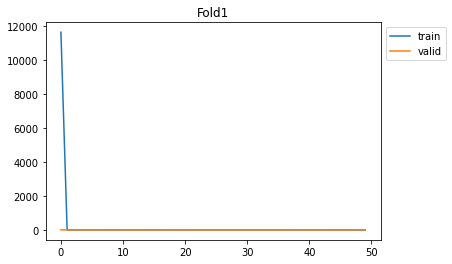

2021-07-20 20:13:28,892 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp013/cv_fold1_training.csv (2093.438 seconds passed)
2021-07-20 20:13:28,911 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp013/cv_fold1_validation.csv (2093.458 seconds passed)
2021-07-20 20:13:28,933 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp013/cv_fold1_test.csv (2093.479 seconds passed)
2021-07-20 20:13:31,288 - __main__ - DEBUG - Save model ../scripts/../experiments/exp013/cv_fold1_model.torch (2095.834 seconds passed)
2021-07-20 20:13:31,429 - __main__ - DEBUG - Complete fold 1 (2095.976 seconds passed)
2021-07-20 20:13:31,433 - __main__ - DEBUG - Start fold 2 (2095.979 seconds passed)
2021-07-20 20:13:31,442 - __main__ - DEBUG - Start training model (2095.989 seconds passed)
2021-07-20 20:13:33,295 - __main__ - DEBUG - Epoch 0/49
2021-07-20 20:13:49,403 - __main__ - DEBUG - train Loss: 11558.0833
2021-07-20 20:13:52,711 - __main__ - D

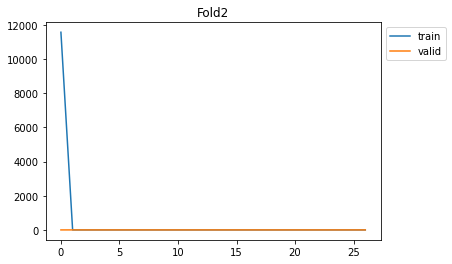

2021-07-20 20:22:51,358 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp013/cv_fold2_training.csv (2655.905 seconds passed)
2021-07-20 20:22:51,371 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp013/cv_fold2_validation.csv (2655.918 seconds passed)
2021-07-20 20:22:51,393 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp013/cv_fold2_test.csv (2655.939 seconds passed)
2021-07-20 20:22:53,512 - __main__ - DEBUG - Save model ../scripts/../experiments/exp013/cv_fold2_model.torch (2658.058 seconds passed)
2021-07-20 20:22:53,631 - __main__ - DEBUG - Complete fold 2 (2658.178 seconds passed)
2021-07-20 20:22:53,633 - __main__ - DEBUG - Start fold 3 (2658.180 seconds passed)
2021-07-20 20:22:53,643 - __main__ - DEBUG - Start training model (2658.190 seconds passed)
2021-07-20 20:22:55,415 - __main__ - DEBUG - Epoch 0/49
2021-07-20 20:23:11,337 - __main__ - DEBUG - train Loss: 12477.1919
2021-07-20 20:23:14,996 - __main__ - D

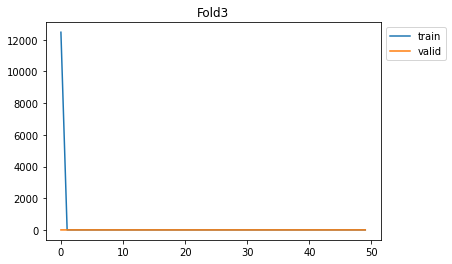

2021-07-20 20:39:35,572 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp013/cv_fold3_training.csv (3660.118 seconds passed)
2021-07-20 20:39:35,587 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp013/cv_fold3_validation.csv (3660.133 seconds passed)
2021-07-20 20:39:35,610 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp013/cv_fold3_test.csv (3660.156 seconds passed)
2021-07-20 20:39:37,809 - __main__ - DEBUG - Save model ../scripts/../experiments/exp013/cv_fold3_model.torch (3662.355 seconds passed)
2021-07-20 20:39:37,911 - __main__ - DEBUG - Complete fold 3 (3662.458 seconds passed)
2021-07-20 20:39:37,933 - __main__ - DEBUG - Start fold 4 (3662.479 seconds passed)
2021-07-20 20:39:37,945 - __main__ - DEBUG - Start training model (3662.491 seconds passed)
2021-07-20 20:39:39,841 - __main__ - DEBUG - Epoch 0/49
2021-07-20 20:39:55,952 - __main__ - DEBUG - train Loss: 11591.1858
2021-07-20 20:39:59,426 - __main__ - D

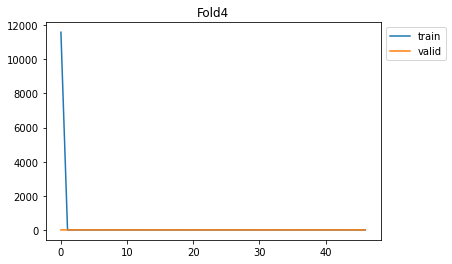

2021-07-20 20:55:24,610 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp013/cv_fold4_training.csv (4609.156 seconds passed)
2021-07-20 20:55:24,624 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp013/cv_fold4_validation.csv (4609.170 seconds passed)
2021-07-20 20:55:24,647 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp013/cv_fold4_test.csv (4609.193 seconds passed)
2021-07-20 20:55:26,819 - __main__ - DEBUG - Save model ../scripts/../experiments/exp013/cv_fold4_model.torch (4611.366 seconds passed)
2021-07-20 20:55:26,929 - __main__ - DEBUG - Complete fold 4 (4611.476 seconds passed)
2021-07-20 20:55:26,931 - __main__ - DEBUG - Start fold 5 (4611.478 seconds passed)
2021-07-20 20:55:26,943 - __main__ - DEBUG - Start training model (4611.490 seconds passed)
2021-07-20 20:55:28,819 - __main__ - DEBUG - Epoch 0/49
2021-07-20 20:55:44,952 - __main__ - DEBUG - train Loss: 13211.1371
2021-07-20 20:55:48,296 - __main__ - D

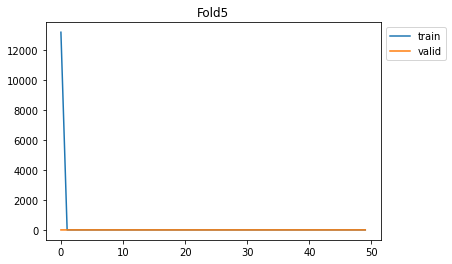

2021-07-20 21:12:05,710 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp013/cv_fold5_training.csv (5610.256 seconds passed)
2021-07-20 21:12:05,723 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp013/cv_fold5_validation.csv (5610.269 seconds passed)
2021-07-20 21:12:05,744 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp013/cv_fold5_test.csv (5610.290 seconds passed)
2021-07-20 21:12:08,727 - __main__ - DEBUG - Save model ../scripts/../experiments/exp013/cv_fold5_model.torch (5613.274 seconds passed)
2021-07-20 21:12:08,827 - __main__ - DEBUG - Complete fold 5 (5613.374 seconds passed)


In [ ]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # Separate dataset into training/validation fold
    y_train = train.loc[train_object_ids, TARGET].values
    y_valid = train.loc[valid_object_ids, TARGET].values
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Prepare model
    model, input_size = initialize_model(MODEL_NAME)
    model.to(DEVICE)
    ## Prepare transformers
    train_transformer = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transformer = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # Prepare dataset
    train_dataset = AtmaImageDatasetV02(train_object_ids, train_transformer, y_train)
    val_dataset = AtmaImageDatasetV02(valid_object_ids, val_transformer, y_valid)
    # Prepare dataloader
    dataloaders = {
        'train': DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()),
        'val': DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()),
    }
    ## train estimator
    estimator, train_losses, valid_losses = train_model(
        model, dataloaders, criterion=nn.MSELoss(), num_epochs=NUM_EPOCHS, device=DEVICE,
        optimizer=torch.optim.Adam(model.parameters()), log_func=logger.debug,
        is_inception=MODEL_NAME == 'inception')
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Visualize training loss
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.legend(loc='upper left', bbox_to_anchor=[1., 1.])
    plt.title(f'Fold{num_fold}')
    plt.show()
    
    # Save model and prediction
    ## Prediction
    if REGRESSION:
        predictions = {}
        for fold_, object_ids_ in zip(['train', 'val', 'test'],
                                     [train_object_ids, valid_object_ids, test['object_id']]):
            # Prepare transformer
            transformer_ = transforms.Compose([
                transforms.Resize(input_size),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            # Prepare dataset
            dataset_ = AtmaImageDatasetV02(object_ids_, transformer_)
            # Prepare dataloader
            dataloader_ = DataLoader(dataset=dataset_, batch_size=BATCH_SIZE, shuffle=False,
                                     num_workers=os.cpu_count())
            # Prediction
            predictions[fold_] = predict_by_model(estimator, dataloader_, DEVICE)
        pred_train = pd.DataFrame(data=predictions['train'], columns=['pred'])
        pred_valid = pd.DataFrame(data=predictions['val'], columns=['pred'])
        pred_test = pd.DataFrame(data=predictions['test'], columns=['pred'])
    else:  # Do not come here!
        raise NotImplemented
        try:
            pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                                     columns=estimator.classes_)
        except AttributeError:
            pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
                                     columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.torch')
    torch.save(estimator.state_dict(), filepath_fold_model)
#     with open(filepath_fold_model, 'wb') as f:
#         pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Evaluation

In [ ]:
rmse = partial(mean_squared_error, squared=False)

In [ ]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [ ]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [ ]:
metrics = defaultdict(list)

## Training set

In [ ]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
            pred_train_df['actual'] = np.vectorize(soring_date2target)(pred_train_df['actual'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-20 21:12:08,895 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-20 21:12:08,934 - __main__ - DEBUG - Loss: 1.0122790499144025
2021-07-20 21:12:08,936 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-20 21:12:08,949 - __main__ - DEBUG - Loss: 1.0199749408481869
2021-07-20 21:12:08,951 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-20 21:12:08,963 - __main__ - DEBUG - Loss: 0.9877055008489338
2021-07-20 21:12:08,965 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-20 21:12:08,977 - __main__ - DEBUG - Loss: 0.9995006597023367
2021-07-20 21:12:08,978 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-20 21:12:08,995 - __main__ - DEBUG - Loss: 0.9643320222983528


In [ ]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_train['actual'] = np.vectorize(soring_date2target)(pred_train['actual'])
# for c in ('pred', 'actual'):
#     pred_train[c] = pred_train[c].astype('int')
pred_train

,pred,actual
object_id,,
002bff09b09998d0be65,1.10227,1
00309fb1ef05416f9c1f,1.49734,3
003a1562e97f79ba96dc,1.31749,3
004890880e8e7431147b,1.25782,2
00718c32602425f504c1,1.20561,3
...,...,...
ffa3259fff8e6f3818a1,1.25677,3
ffd4d361756587883e48,0.99480,1
ffd794b7b311b7b7fd92,1.50226,2


In [ ]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-20 21:12:09,069 - __main__ - INFO - Training loss: 1.1183355731700308


In [ ]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-20 21:12:09,094 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp013/prediction_train.csv


## Validation set

In [ ]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
            pred_valid_df['actual'] = np.vectorize(soring_date2target)(pred_valid_df['actual'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-20 21:12:09,124 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-20 21:12:09,134 - __main__ - DEBUG - Loss: 1.0094633125088632
2021-07-20 21:12:09,135 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-20 21:12:09,145 - __main__ - DEBUG - Loss: 1.0279990101317786
2021-07-20 21:12:09,146 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-20 21:12:09,156 - __main__ - DEBUG - Loss: 0.9725606321551069
2021-07-20 21:12:09,157 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-20 21:12:09,167 - __main__ - DEBUG - Loss: 1.0392382543270906
2021-07-20 21:12:09,168 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-20 21:12:09,178 - __main__ - DEBUG - Loss: 0.9605361588581969


In [ ]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_valid['actual'] = np.vectorize(soring_date2target)(pred_valid['actual'])
# for c in ('pred', 'actual'):
#     pred_valid[c] = pred_valid[c].astype('int')
pred_valid

,pred,actual
object_id,,
002bff09b09998d0be65,0.27385,1
00309fb1ef05416f9c1f,0.33094,3
003a1562e97f79ba96dc,0.31427,3
004890880e8e7431147b,0.29689,2
00718c32602425f504c1,0.32143,3
...,...,...
ffa3259fff8e6f3818a1,0.28638,3
ffd4d361756587883e48,0.26521,1
ffd794b7b311b7b7fd92,0.34411,2


In [ ]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

2021-07-20 21:12:09,221 - __main__ - INFO - Validatino loss: 1.7810997765991408


In [ ]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-20 21:12:09,252 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp013/prediction_valid.csv


In [ ]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-20 21:12:09,270 - __main__ - DEBUG - Write metrics to ../scripts/../experiments/exp013/metrics.json


# Prediction

In [ ]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [ ]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,pred
object_id,
0009e50b94be36ccad39,1.35950
000bd5e82eb22f199f44,1.60098
0015f44de1854f617516,1.43764
00388a678879ba1efa27,1.57311
005e1e7c6496902d23f3,1.26427
...,...
ffbe65ad399b632dcbd0,1.52429
ffd7b2d646c0320c311a,1.19533
ffdb93ede17d4501e530,1.57299


In [ ]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1.35950
1,1.60098
2,1.43764
3,1.57311
4,1.26427
...,...
5914,1.52429
5915,1.19533
5916,1.57299
5917,1.37747


In [ ]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [ ]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-20 21:12:09,418 - __main__ - DEBUG - Write submission to ../scripts/../experiments/exp013/013_submission.csv


2021-07-20 21:12:09,601 - __main__ - DEBUG - Write figure to ../scripts/../experiments/exp013/prediction.png


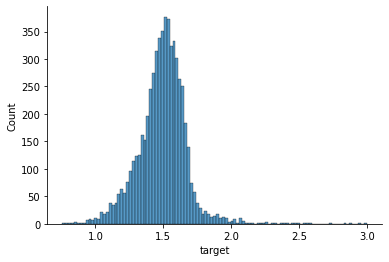

In [ ]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [ ]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-20 21:12:09,861 - __main__ - DEBUG - Complete (5614.408 seconds passed)
